In [1]:
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
import random
import os
import json
from tabulate import tabulate
from scipy.stats import kde

In [2]:
def plot_heat_map(x,y,nbins):
    k = kde.gaussian_kde((x,y))
    xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    return plt.pcolormesh(yi, xi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.gist_heat)

In [3]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
    

### To Do
* Graph distribution of size
* Graph distribution of size vs number of modis matches 
* Map modis detection around a particular kaggle wildfire
* Could modis detect a fire after "CONT_DATE"?
* Find appropriate error margins
* Evaluate error rate#
* Reduce redundancy in searching for matches from each database

## Load and Process Datasets

### Kaggle

In [4]:
cnx = sqlite3.connect("FPA_FOD_20170508.sqlite")

kaggle = pd.read_sql_query("""
SELECT FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE, DISCOVERY_TIME, CONT_DATE, CONT_TIME, FIRE_SIZE 
FROM 'Fires'
ORDER BY LATITUDE DESC
""", cnx)


kaggle['DISCOVERY_DATE'] = pd.to_datetime(kaggle['DISCOVERY_DATE'], origin="julian", unit="D")# - pd.Timestamp(0).to_julian_date(), unit='D')

kaggle['CONT_DATE'] = pd.to_datetime(kaggle['CONT_DATE'], origin="julian", unit="D")# - pd.Timestamp(0).to_julian_date(), unit='D')

kaggle["LATITUDE"] = pd.to_numeric(kaggle["LATITUDE"])
kaggle["LONGITUDE"] = pd.to_numeric(kaggle["LONGITUDE"])


modis_start_date = datetime(2000, 1, 1)
filter_old_data = kaggle["CONT_DATE"] > modis_start_date
kaggle = kaggle[filter_old_data]

### Modis

In [5]:
with open("fire_archive_M6_91543.json", "r") as jfile:
    modis1=json.loads(jfile.read())
    
modis = pd.DataFrame.from_dict(modis1)

modis.columns = modis.columns.map(lambda x: x.upper())

modis["LATITUDE"] = pd.to_numeric(modis["LATITUDE"])
modis["LONGITUDE"] = pd.to_numeric(modis["LONGITUDE"])

modis['ACQ_DATE'] = pd.to_datetime(modis['ACQ_DATE'])

Take smaller sample data sets for testing

In [7]:
# take extract of dataset for testing
smpl_upper_bound = datetime(year=2007, month=2, day=1)
smpl_lower_bound = datetime(year=2007, month=1, day=1)

mf1 = modis["ACQ_DATE"] < smpl_upper_bound
mf1n2 = (modis["ACQ_DATE"] >= smpl_lower_bound) & mf1

modis = modis[mf1n2].copy()

kf1 = kaggle["DISCOVERY_DATE"] < smpl_upper_bound
kf1n2 = (kaggle["CONT_DATE"] >= smpl_lower_bound) & kf1

kaggle = kaggle[kf1n2].copy()

## Sample Datasets

### KAGGLE

In [61]:
kaggle.loc()[kaggle["FIRE_SIZE"].idxmax()]

FIRE_YEAR                          2006
STAT_CAUSE_DESCR                  Arson
LATITUDE                        34.4497
LONGITUDE                      -85.5978
STATE                                AL
DISCOVERY_DATE      2006-03-05 00:00:00
DISCOVERY_TIME                     1145
CONT_DATE           2008-03-09 00:00:00
CONT_TIME                          1400
FIRE_SIZE                           900
Name: 1108148, dtype: object

In [8]:
print("KAGGLE")
print("Number of wilfires:" + str(len(kaggle)))
print()
print("Earliest and latest fires: ")
min_max = [kaggle["DISCOVERY_DATE"].idxmin(),
           kaggle["CONT_DATE"].idxmax()]

display(kaggle.loc()[min_max, ["DISCOVERY_DATE", "CONT_DATE"]])

print()
print("Sample:")
display(kaggle.head())

KAGGLE
Number of wilfires:752

Earliest and latest fires: 


,DISCOVERY_DATE,CONT_DATE
372687,1997-08-10,2007-08-10
630417,2001-05-14,2010-05-14



Sample:


,FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,DISCOVERY_TIME,CONT_DATE,CONT_TIME,FIRE_SIZE
3859,2006,Campfire,64.7800,-147.3500,AK,2006-06-05,1427,2007-06-05,1515,0.2
26169,2007,Powerline,48.5991,-113.1251,MT,2007-01-02,1730,2007-01-02,2000,2.0
27682,2007,Children,48.5653,-113.0115,MT,2007-01-27,1250,2007-01-27,1330,3.0
28843,2007,Equipment Use,48.5419,-113.0156,MT,2007-01-29,1558,2007-01-29,1619,0.1
31757,2007,Arson,48.4569,-108.7485,MT,2007-01-25,2026,2007-01-25,2115,0.1


### MODIS

In [9]:
print("MODIS")
print("Number of wilfires:" + str(len(kaggle)))
print()
print("Earliest and latest fires: ")
min_max = [modis["ACQ_DATE"].idxmin(),
           modis["ACQ_DATE"].idxmax()]

display(modis.loc()[min_max, ["ACQ_DATE", "ACQ_TIME"]])

print()
print("Sample:")
display(modis.head())

MODIS
Number of wilfires:752

Earliest and latest fires: 


,ACQ_DATE,ACQ_TIME
699190,2007-01-01,0442
701987,2007-01-31,0019



Sample:


,LATITUDE,LONGITUDE,ACQ_DATE,ACQ_TIME,TYPE,BRIGHTNESS,CONFIDENCE,FRP,SATELLITE,TRACK,SCAN,INSTRUMENT,BRIGHT_T31,DAYNIGHT,VERSION
699190,46.6931,-94.9139,2007-01-01,0442,0,305.3,26,28.0,Terra,1.3,1.7,MODIS,266.6,N,6.2
699191,19.3520,-155.0578,2007-01-01,0753,2,316.3,91,148.9,Terra,2.0,4.8,MODIS,288.9,N,6.2
699192,19.3347,-155.0514,2007-01-01,0753,2,314.1,84,130.6,Terra,2.0,4.8,MODIS,290.6,N,6.2
699193,19.3530,-155.0519,2007-01-01,0753,2,313.8,83,132.1,Terra,2.0,4.8,MODIS,289.0,N,6.2
699194,19.3496,-155.0612,2007-01-01,1217,2,345.3,100,67.8,Aqua,1.1,1.2,MODIS,293.6,N,6.2


## Map

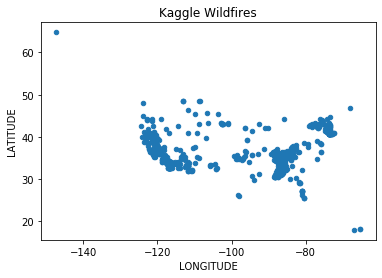

In [10]:
kaggle.plot(x ='LONGITUDE', y='LATITUDE', kind = 'scatter', title="Kaggle Wildfires")

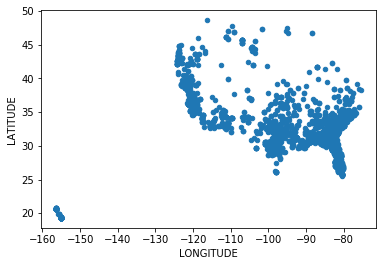

In [11]:
modis.plot(x ='LONGITUDE', y='LATITUDE', kind = 'scatter')

## Heatmap

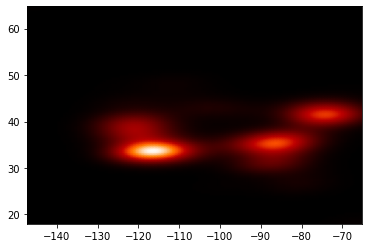

In [12]:
plot_heat_map(kaggle["LATITUDE"], kaggle["LONGITUDE"], 120)

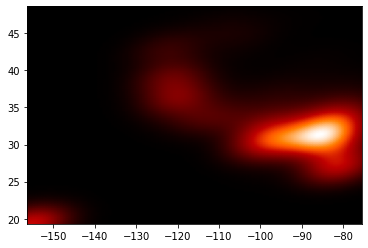

In [13]:
plot_heat_map(modis["LATITUDE"], modis["LONGITUDE"], 120)

# Compare Datasets

In [14]:
def find_match_indeces_in_modis(k_row, day_margin, lat_margin, long_margin, modis_df):
    lat = k_row["LATITUDE"]
    long = k_row["LONGITUDE"]
    date_disc = k_row["DISCOVERY_DATE"]
    date_cont = k_row["CONT_DATE"]
    
    
    lb = date_disc - timedelta(days=day_margin)
    
    check_time = (lb <= modis_df["ACQ_DATE"]) & (modis_df["ACQ_DATE"] <= date_cont)
    
    check_long = abs(long - modis_df["LONGITUDE"]) < long_margin
    check_lat = abs(lat - modis_df["LATITUDE"]) < lat_margin
    
    return (check_time & check_long & check_lat)

In [15]:
def find_match_indeces_in_kaggle(m_row, day_margin, lat_margin, long_margin, kaggle_df):
    lat = m_row["LATITUDE"]
    long = m_row["LONGITUDE"]
    date_aq = m_row["ACQ_DATE"]    
    
    lb = date_aq + timedelta(days=day_margin)
    
    check_time = (lb <= kaggle_df["DISCOVERY_DATE"]) & (date_aq <= kaggle_df["CONT_DATE"])
    
    check_long = abs(long - kaggle_df["LONGITUDE"]) < long_margin
    check_lat = abs(lat - kaggle_df["LATITUDE"]) < lat_margin
    
    return (check_time & check_long & check_lat)

In [16]:
k_results_hits = {}
k_results_freq = {}

m_results_hits = {}
m_results_freq = {}


date_ivs = [0, 2, 4]

# Probably expensive to calculate the actual distance between points
ll_ivs = [0.001, 0.01, 1]

kag_matches = {}
mod_matches = {}

for dm in date_ivs:
    for llm in ll_ivs:
        print(llm, dm)
        
        m_finder = lambda x: find_match_indeces_in_modis(k_row=x,
                                                         day_margin=dm,
                                                         lat_margin=llm,
                                                         long_margin=llm,
                                                         modis_df=modis)
        k_hits = kaggle.apply(m_finder, axis=1)
        
        kag_matches[(llm,dm)] = kaggle.assign(matches=k_hits.values.tolist(),
                                              num_matches=list(map(sum, k_hits.values.tolist())))
        
        
        k_finder = lambda x: find_match_indeces_in_kaggle(m_row=x,
                                                          day_margin=dm,
                                                          lat_margin=llm,
                                                          long_margin=llm,
                                                          kaggle_df=kaggle)
        
        m_hits = modis.apply(k_finder, axis=1)

        mod_matches[(llm,dm)] = modis.assign(matches = m_hits.values.tolist(), 
                                             num_matches = list(map(sum, m_hits.values.tolist())))
        
        
        k_results_hits[(llm,dm)] = k_hits
        
        m_results_hits[(llm,dm)] = m_hits

0.001 0
0.01 0
1 0
0.001 2
0.01 2
1 2
0.001 4
0.01 4
1 4


In [49]:
k_no_hits_by_row = {}
m_no_hits_by_row = {}
for dm in date_ivs:
    for llm in ll_ivs:     
        k_no_hits_by_row[(llm,dm)] = k_results_hits[(llm,dm)].apply(sum)
        m_no_hits_by_row[(llm,dm)] = m_results_hits[(llm,dm)].apply(sum)

In [21]:
display_grid = [[""]*len(ll_ivs)]*len(date_ivs)
x = 0
y = 0
for dm in date_ivs:
    y = 0
    for llm in ll_ivs:
        print(llm, dm)
        k_hits_hist = np.histogram(k_no_hits_by_row[(llm,dm)], bins = [0,1,2,4,8,10,1000])
        display_grid[x][y] = (tabulate([k_hits_hist[1], k_hits_hist[0]], headers=["Bins", "Hits ({})".format(str((dm,llm)))])) + "\n   \n  "
        
        y += 1
    x += 1

0.001 0
0.01 0
1 0
0.001 2
0.01 2
1 2
0.001 4
0.01 4
1 4


In [72]:
print(tabulate(display_grid))

-------------------------------------------------  ------------------------------------------------  ------------------------------------------------
Bins    Hits ((4, 0.001))                          Bins    Hits ((4, 0.01))                          Bins    Hits ((4, 1))
----  --  --  --  --  ------  -------------------  ----  --  --  --  --  ------  ------------------  ----  ---  ---  ---  --  ------  ---------------
   0   1   2   4   8      10                 1000     0   1   2   4   8      10                1000     0    1    2    4   8      10             1000
3093   0   0   0   0       0                       3086   7   0   0   0       0                      1935  427  375  237  58      61
Bins    Hits ((4, 0.001))                          Bins    Hits ((4, 0.01))                          Bins    Hits ((4, 1))
----  --  --  --  --  ------  -------------------  ----  --  --  --  --  ------  ------------------  ----  ---  ---  ---  --  ------  ---------------
   0   1   2   4   8 

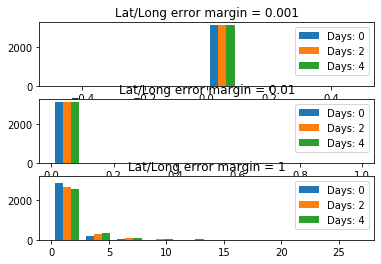

In [71]:
f, axs = plt.subplots(3, 1, sharey=True)#, sharex=True)

for a0, ax in enumerate(axs):
    llm = ll_ivs[a0]

    d1 = [k_no_hits_by_row[(llm,dm)] for dm in date_ivs]
    ls = ["Days: " + str(dm) for dm in date_ivs]
    
    if a0 == 2:
        pass#break
    
    ax.hist(d1, label=ls)
    ax.legend(loc='upper right')
    ax.set_title("Lat/Long error margin = " + str(llm))

plt.show()

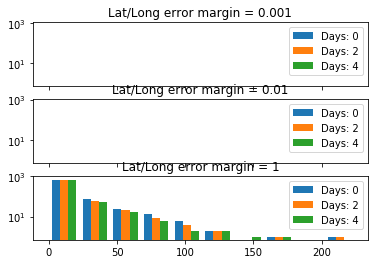

In [53]:
f, axs = plt.subplots(3, 1, sharey=True, sharex=True)

for a0, g in enumerate(axs):
    llm = ll_ivs[a0]

    d1 = [m_no_hits_by_row[(llm,dm)] for dm in date_ivs] 
    ls = ["Days: " + str(dm) for dm in date_ivs] 
    
    g.hist(d1, label=ls)
    g.legend(loc='upper right')
    g.set_title("Lat/Long error margin = " + str(llm))

    g.set_yscale("log")

In [ ]:
# kag_smpl["match_dict 1 1"] = kag_smpl_with_matches[(0.01,1)]["matches"]
# kag_smpl["match_dict 10 1"] = kag_smpl_with_matches[(0.01,5)]["matches"]
# kag_smpl["match_dict 1 10"] = kag_smpl_with_matches[(1,1)]["matches"]
# kag_smpl["match_dict 10 10"] = kag_smpl_with_matches[(1,5)]["matches"]

# def verify(k_row):
#     return (pd.Series(k_row["match_dict 1 1"]) & (~ pd.Series(k_row["match_dict 10 1"]))).any()
    
# bools = kag_smpl.apply(verify, axis=1)
# print(bools.shape)
# print(sum(bools))
# kag_smpl[bools].head()

Trying to visualise the data:

In [ ]:
# i = 0
# f, axs = plt.subplots(len(date_ivs), len(ll_ivs), figsize=(20,20))
# f.patch.set_facecolor("#FFFFFF")
# ax_l = []




# for d in date_ivs:
#     for l in ll_ivs:
#         hist = kag_smpl_with_matches[(l,d)]["num_matches"].hist(bins=[])
                
#         if len(ax_l) == 0:
#             new = plt.subplot(len(date_ivs), len(ll_ivs), i+1)
#         else:
#             new = plt.subplot(len(date_ivs), len(ll_ivs), i+1, sharex=ax_l[0], sharey=ax_l[0])
            
#         new.set_xlabel("Number of matches in Modis")
#         #new.set_xscale("log")
        
#         new.set_ylabel("Number of wildfires in kaggle with that many matches")
#         new.set_yscale("log")
#         new.set_ylim([1,10**3])

#         new.set_title("Days: {days}, Degrees: {deg}". format(days=d, deg=l))
#         ax_l.append(new)

#         i += 1